In [1]:
import numpy as np
import pandas as pd

np.random.seed(0)
df = pd.read_csv('./data/gept-3.csv',encoding = "ISO-8859-1")  # 

df = df.reindex(np.random.permutation(df.index))  # 打亂 df 的排序 np.random.permutation()

df.head(3)

,article,rating
63,Don't miss this once-in-a-lifetime opportunity...,2
247,With millions graduating from college each yea...,1
293,During one such meeting they decided to give t...,1


In [2]:
# 詞袋模型: 句子 -> 單字 -> 詞袋(稀疏矩陣)
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()

In [3]:
# 計算 TF-IDF, 使用 L2正規化 
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

In [4]:
# 文件清理
# 用正規表示式
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # 清除 HTML
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # 清除 標點符號
    text = re.sub('[\W]+', ' ', text.lower()) + \
           ' '.join(emoticons).replace('-', '') # 非字元符號, - 
    return text

In [5]:
# 所有文本清除前
print(df['article'].head(20))

63     Don't miss this once-in-a-lifetime opportunity...
247    With millions graduating from college each yea...
293    During one such meeting they decided to give t...
124    I hope to do as much swimming this summer as I...
188    Neil: Are you psyched? Ashley: About what? Nei...
144    On Aug 14th, huge, fiery blasts at a warehouse...
299    For now, the lights still cost more than the a...
65     In public service lectures, fire fighters not ...
26     Nancy gained four kilograms during the holiday...
66     After the police arrive, they will begin to in...
280    "I work well under pressure because I use the ...
90     Taroko Gorge, a well-known scenic spot, is loc...
213    Walter Cronkite, who died on July 17, became k...
55     According to newspaper reports, flooding in th...
22     After we ate the fried chicken, our fingers we...
200    I'm hoping ......the boy hesitated, fumbling i...
238    The ants' story began a little over a ago, in ...
230    Teddy, 77, is a figure n

In [6]:
# 所有文本清除後
df['article'] = df['article'].apply(preprocessor)
print(df['article'].head(20))

63     don t miss this once in a lifetime opportunity...
247    with millions graduating from college each yea...
293    during one such meeting they decided to give t...
124    i hope to do as much swimming this summer as i...
188    neil are you psyched ashley about what neil as...
144    on aug 14th huge fiery blasts at a warehouse f...
299    for now the lights still cost more than the av...
65     in public service lectures fire fighters not o...
26     nancy gained four kilograms during the holiday...
66     after the police arrive they will begin to int...
280     i work well under pressure because i use the ...
90     taroko gorge a well known scenic spot is locat...
213    walter cronkite who died on july 17 became kno...
55     according to newspaper reports flooding in the...
22     after we ate the fried chicken our fingers wer...
200    i m hoping the boy hesitated fumbling in his p...
238    the ants story began a little over a ago in 19...
230    teddy 77 is a figure not

In [7]:
# 文件轉為字符
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):  # 方法1. 空白字元斷字
    text = re.sub('<[^>]*>', '', text) # 清除 HTML
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # 清除 標點符號
    text = re.sub('[\W]+', ' ', text.lower()) + \
           ' '.join(emoticons).replace('-', '') # 非字元符號, - 
    
    #text = re.sub('<[^>]*>', '', text)
    #emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    #text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized
    #return text.split()
def tokenizer_porter(text): # 方法2. 字詞 -> 字根
    tokenized=[porter.stem(word) for word in text.split()]
    return tokenized

In [8]:
# 命令提示字元 執行 pip install nltk
# 處理停用字(常見但又無用的字, is and or...)
import nltk
nltk.download('stopwords')

# 使用英文停用字集
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/m/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:,'article'], df.loc[:, 'rating'], test_size=0.2, random_state=0)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
# 網格法搜尋最佳參數組合
# TfidfVectorizer -> 字詞轉特徵值 與 計算TF-IDF
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None, 
                        lowercase=False, 
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1,1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0]},
              {'vect__ngram_range': [(1,1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0]},
             ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, 
                           scoring='accuracy',
                           cv=5, verbose=1,
                           n_jobs=-1)

#gs_lr_tfidf.fit(X_train, y_train)
gs_lr_tfidf.fit(X_train, y_train)
# 最佳參數組合
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s


Best parameter set: {'vect__tokenizer': <function tokenizer at 0x108c1b510>, 'clf__penalty': 'l2', 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.2s finished


In [13]:
# 訓練資料集的套用最佳參數組合
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

CV Accuracy: 0.789


In [15]:
# 測試資料集套用最佳參數組合的正確率
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.758


In [16]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings
from sklearn.learning_curve import learning_curve



#畫圖的function  plot_decision_regions
def learnCurve(classifier,train_vector, y_train,title):
    plt_title = title
    train_sizes, train_scores, test_scores =\
                learning_curve(estimator=classifier, 
                X=train_vector, 
                y=y_train, 
                train_sizes=np.linspace(0.1, 1.0, 10), 
                cv=10,
                n_jobs=1)
        

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5, label='training accuracy')

    plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,color='green', linestyle='--', marker='s', markersize=5,label='validation accuracy')

    plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.1, 1.0])
    plt.tight_layout()
    plt.title(plt_title)
    # plt.savefig('./figures/learning_curve.png', dpi=300)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [17]:
# Perform classification with LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(strip_accents=None, 
                        lowercase=False, 
                        preprocessor=None)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.fit_transform(X_test)

import time
classifier_Logistic = clf
t0 = time.time()
#Logistic_KNN = classifier_Logistic.fit(train_vectors, y_train)
t1 = time.time()
prediction_Logistic = classifier_Logistic.predict(X_test)
prediction_Logistic_score = accuracy_score(y_test, prediction_Logistic)  #評分方式 accuracy_score()
t2 = time.time()
time_Logistic_train = t1-t0
time_Logistic_predict = t2-t1

Results for LogisticRegression GEPT-GEPT
Accuracy: 0.76
Training time: 0.000027s; Prediction time: 0.023959s
             precision    recall  f1-score   support

          1       0.74      0.81      0.77        31
          2       0.79      0.71      0.75        31

avg / total       0.76      0.76      0.76        62



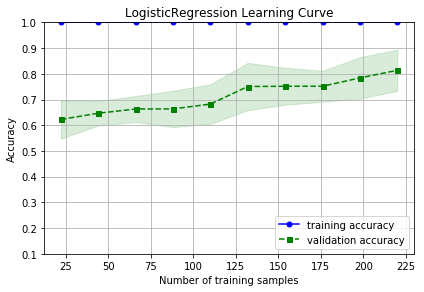

In [18]:


print("Results for LogisticRegression GEPT-GEPT")
print('Accuracy: %.2f' % prediction_Logistic_score)
print("Training time: %fs; Prediction time: %fs" % (time_Logistic_train, time_Logistic_predict))
print(classification_report(y_test, prediction_Logistic))

learnCurve(classifier_Logistic,X_train,y_train,'LogisticRegression Learning Curve')
plt.show()